# Consumption prediction
### Author : Nicolas Lacroix (https://github.com/NicolasLacroix)

Licence : [Apache License 2.0]

This notebook uses [consumption.ipynb] and [meteorology.ipynb].

[Apache License 2.0]: https://github.com/NicolasLacroix/data-representation/blob/master/LICENSE

[consumption.ipynb]: https://github.com/NicolasLacroix/data-representation/blob/master/notebooks/consumption.ipynb
[meteorology.ipynb]: https://github.com/NicolasLacroix/data-representation/blob/master/notebooks/meteorology.ipynb

In [191]:
import torch
import torch.nn as nn

## I. Data

### Importing data

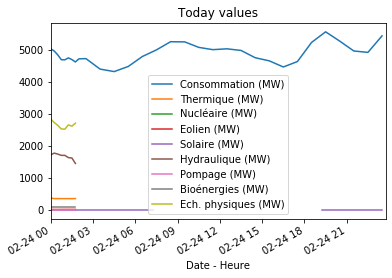

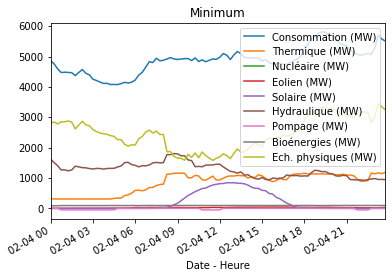

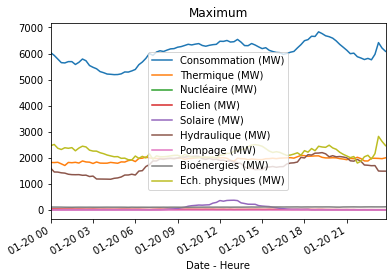

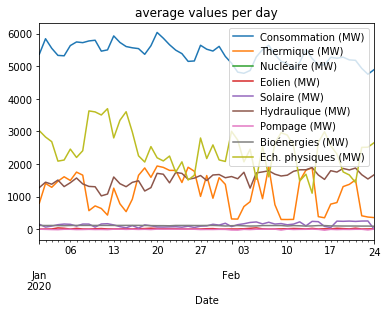

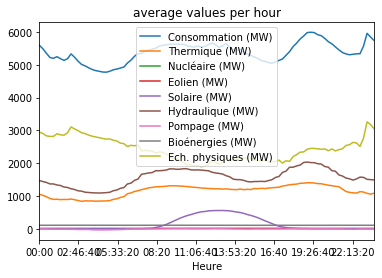

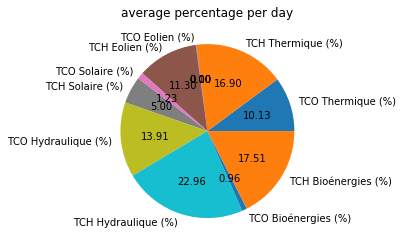

datetime64[ns, Europe/Paris]
(115233, 81)
datetime64[ns, Europe/Paris]
datetime64[ns, Europe/Paris]
datetime64[ns, Europe/Paris]
(29003, 18)
datetime64[ns, Europe/Paris]
datetime64[ns, Europe/Paris]
datetime64[ns]


meteorology.ipynb:4: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and 'the values will not compare equal to the
'datetime.date'. To retain the current behavior, convert the
'datetime.date' to a datetime with 'pd.Timestamp'.
  "cell_type": "markdown",


datetime64[ns]


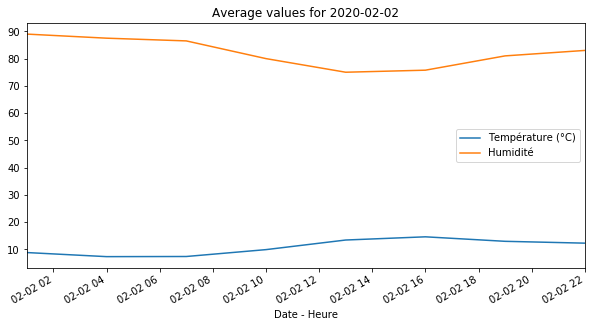

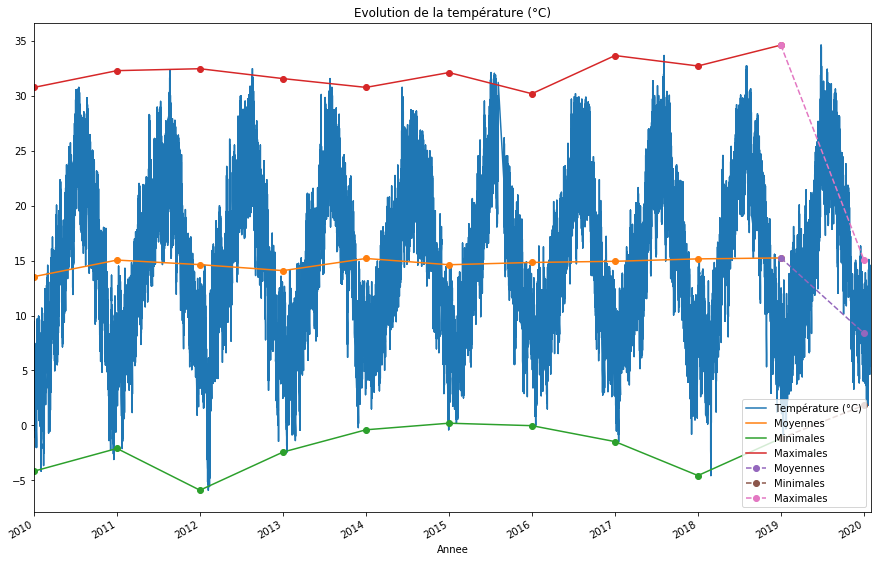

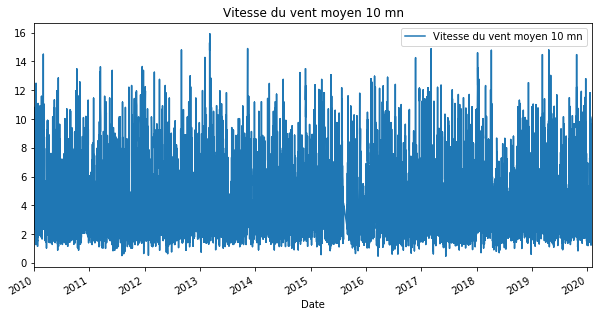

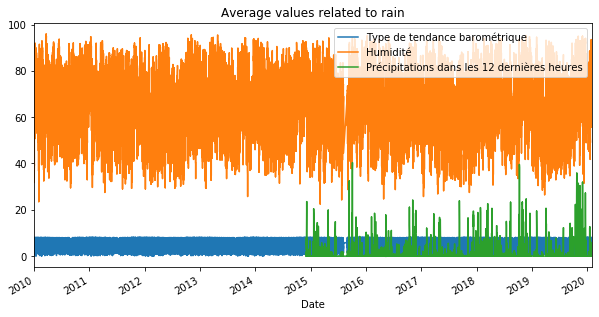

In [192]:
%run consumption.ipynb # import data
%run meteorology.ipynb # import data_meteo

### Processing data

In [193]:
print(data_meteo['Date'].dtypes == data['Date'].dtypes)
# converting data_meteo['Date']'s type to match data['Date']'s type
#data_meteo['Date'] = pd.to_datetime(data_meteo['Date'])
print(data['Date'].dtypes == data_meteo['Date'].dtypes)
print(data['Date'].dtypes)
print(data_meteo['Date'].dtypes)
# converting data['Date - Heure']

True
True
datetime64[ns]
datetime64[ns]


In [194]:
print(data.dtypes)
data_meteo.dtypes

Code INSEE région               int64
Région                         object
Nature                         object
Date                   datetime64[ns]
Heure                          object
                            ...      
TCO Hydraulique (%)           float64
TCH Hydraulique (%)           float64
TCO Bioénergies (%)           float64
TCH Bioénergies (%)           float64
Column 26                     float64
Length: 28, dtype: object


Date                                                         datetime64[ns]
Annee                                                                 int64
Heure                                                                object
Date - Heure                                   datetime64[ns, Europe/Paris]
Pression au niveau mer                                              float64
                                                           ...             
Précipitations dans les 3 dernières heures                          float64
Précipitations dans les 6 dernières heures                          float64
Précipitations dans les 12 dernières heures                         float64
Type de tendance barométrique.1                                     float64
Température (°C)                                                    float64
Length: 21, dtype: object

## II. Prediction

In [195]:
TRAIN_SPLIT = 240 # size of the training dataset
NB_DAYS = 10 # number of days to be predicted

### Training dataset

In [196]:
# TODO: normalize all columns or only Consuming ?
# TODO: improve performances
# data_train = pd.concat([data, data_meteo], axis=1, join='inner')[:TRAIN_SPLIT-NB_DAYS]
data_train = pd.merge(data, data_meteo, on=['Date - Heure', 'Date', 'Heure'])[:TRAIN_SPLIT-NB_DAYS]
# normalizing data
data_train_mean = data_train["Consommation (MW)"].mean()
data_train_std = data_train["Consommation (MW)"].std()
data_train["Consommation (MW)"] = (data_train["Consommation (MW)"]-data_train_mean)/data_train_std
# final training dataset
data_train

,Code INSEE région,Région,Nature,Date,Heure,Date - Heure,Consommation (MW),Thermique (MW),Nucléaire (MW),Eolien (MW),...,Temps présent,Pression station,Rafales sur une période,Periode de mesure de la rafale,Précipitations dans la dernière heure,Précipitations dans les 3 dernières heures,Précipitations dans les 6 dernières heures,Précipitations dans les 12 dernières heures,Type de tendance barométrique.1,Température (°C)
0,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-01-01,01:00:00,2020-01-01 01:00:00+01:00,0.186530,1302.0,NaN,2.0,...,0.666667,99910.0,4.375,-10.0,0.000,0.000,0.000,0.000,6.50,4.600
1,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-01-01,07:00:00,2020-01-01 07:00:00+01:00,-1.122267,236.0,NaN,1.0,...,0.666667,99905.0,4.975,-10.0,0.000,0.000,0.000,0.000,3.00,4.150
2,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-01-01,19:00:00,2020-01-01 19:00:00+01:00,0.582010,1781.0,NaN,1.0,...,0.666667,99990.0,6.250,-10.0,0.000,0.000,0.000,0.000,3.00,7.400
3,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-01-02,19:00:00,2020-01-02 19:00:00+01:00,1.903917,1923.0,NaN,4.0,...,3.666667,100000.0,2.950,-10.0,-0.025,-0.025,-0.025,-0.025,2.75,7.800
4,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-01-03,10:00:00,2020-01-03 10:00:00+01:00,0.523015,1579.0,NaN,0.0,...,1.250000,99842.5,6.325,-10.0,0.000,0.000,0.000,0.000,2.75,8.700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-01-11,22:00:00,2020-01-11 22:00:00+01:00,0.081651,511.0,NaN,11.0,...,0.666667,99675.0,4.875,-10.0,0.000,0.000,0.000,0.000,1.50,6.250
226,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-01-12,04:00:00,2020-01-12 04:00:00+01:00,-0.879736,309.0,NaN,7.0,...,0.666667,99692.5,5.400,-10.0,0.000,0.000,0.000,0.000,1.25,4.750
227,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-01-12,07:00:00,2020-01-12 07:00:00+01:00,-0.471146,310.0,NaN,6.0,...,0.666667,99742.5,5.325,-10.0,0.000,0.000,0.000,0.000,3.00,3.625
228,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-01-12,13:00:00,2020-01-12 13:00:00+01:00,0.013917,309.0,NaN,1.0,...,1.000000,99690.0,4.050,-10.0,0.000,0.000,0.000,0.000,8.00,12.050


### Target dataset

In [197]:
target_data = pd.merge(data, data_meteo, on=['Date - Heure', 'Date', 'Heure'])[TRAIN_SPLIT-NB_DAYS:TRAIN_SPLIT]
# TODO : .values.astype(np.float64)
target_data

,Code INSEE région,Région,Nature,Date,Heure,Date - Heure,Consommation (MW),Thermique (MW),Nucléaire (MW),Eolien (MW),...,Temps présent,Pression station,Rafales sur une période,Periode de mesure de la rafale,Précipitations dans la dernière heure,Précipitations dans les 3 dernières heures,Précipitations dans les 6 dernières heures,Précipitations dans les 12 dernières heures,Type de tendance barométrique.1,Température (°C)
230,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-01-14,04:00:00,2020-01-14 04:00:00+01:00,5168.0,654.0,NaN,7.0,...,0.750000,99192.5,5.900,-10.0,0.00,0.000,0.000,-0.025,5.25,5.800
231,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-01-14,07:00:00,2020-01-14 07:00:00+01:00,5810.0,1018.0,NaN,7.0,...,0.750000,99250.0,6.050,-10.0,0.00,0.000,0.000,0.000,3.00,5.875
232,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-01-14,16:00:00,2020-01-14 16:00:00+01:00,5473.0,913.0,NaN,12.0,...,0.750000,99250.0,6.800,-10.0,0.00,0.000,0.000,0.000,5.75,12.675
233,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-01-16,16:00:00,2020-01-16 16:00:00+01:00,5364.0,732.0,NaN,8.0,...,0.666667,99737.5,6.650,-10.0,0.05,0.050,0.050,0.050,5.75,12.175
234,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-01-16,22:00:00,2020-01-16 22:00:00+01:00,5276.0,1087.0,NaN,13.0,...,1.000000,99790.0,6.150,-10.0,0.00,0.000,0.000,0.050,4.25,8.275
235,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-01-17,19:00:00,2020-01-17 19:00:00+01:00,6092.0,1948.0,NaN,16.0,...,44.000000,99115.0,11.000,-10.0,2.35,5.675,7.425,7.625,3.75,6.950
236,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-01-18,13:00:00,2020-01-18 13:00:00+01:00,5578.0,1885.0,NaN,22.0,...,0.333333,99252.5,11.450,-10.0,0.00,0.000,0.000,0.025,8.00,9.125
237,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-01-19,10:00:00,2020-01-19 10:00:00+01:00,5750.0,1490.0,NaN,29.0,...,0.666667,99277.5,7.850,-10.0,0.00,0.000,0.000,0.000,2.50,4.650
238,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-01-19,22:00:00,2020-01-19 22:00:00+01:00,5761.0,1862.0,NaN,31.0,...,0.333333,99720.0,7.775,-10.0,0.00,0.000,0.000,0.000,2.00,5.225
239,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-01-20,07:00:00,2020-01-20 07:00:00+01:00,6003.0,1993.0,NaN,15.0,...,0.666667,99957.5,17.550,-10.0,0.00,0.000,0.000,0.000,3.00,7.050


### Neural Network

In [198]:
# converting data (to pytorch tensor)
input_data = torch.FloatTensor(data_train.select_dtypes(include=['int', 'float']).values)
target = torch.FloatTensor(target_data.select_dtypes(include=['int', 'float']).values)
#target = torch.FloatTensor(target_data.values.reshape((TRAIN_SPLIT, )))
#target = target.unsqueeze(0)

In [199]:
# number of criterias
nbIn = input_data.shape[0]
# neural network caracteristics
nbOut = input_data.shape[1]
nbHidden = int(nbIn/2)
# définition of the neural network
# neuralNetwork = nn.Sequential(nn.Linear(nbIn,nbHidden), nn.ReLU(), nn.Linear(nbHidden,nbOut))
neuralNetwork = nn.Sequential(nn.Linear(nbIn,nbOut), nn.ReLU())
neuralNetwork

Sequential(
  (0): Linear(in_features=230, out_features=39, bias=True)
  (1): ReLU()
)

In [200]:
# launch criterias + optimizing options
criterion = nn.MSELoss() # MSELoss = moindres carrés
optimizer = torch.optim.SGD(neuralNetwork.parameters(), lr=0.000003) # lr = learning rate
nbEpochs = 1000 # nombre d'itérations

### Training

In [201]:
items = []
# launching iterations
for epoch in range(nbEpochs):
    optimizer.zero_grad() # zero_grad = ?
    print(input_data.shape)
    output = neuralNetwork(input_data)
    print(output) # TODO: check output content (maybe prediction results)
    loss = criterion(output, target) # calcul de la fonction cout (moindres carrés)
    loss.backward() # calcul du gradient (sens = droite vers gauche)
    optimizer.step() # ? (modification des parametres du réseau de neurones)
    print(loss.item())
    items.append(loss.item())

torch.Size([230, 39])


RuntimeError: size mismatch, m1: [230 x 39], m2: [230 x 39] at C:\w\1\s\windows\pytorch\aten\src\TH/generic/THTensorMath.cpp:136

### Results

In [ ]:
# neural network performances (loss stats)
fig, ax = plt.subplots()
x = np.arange(len(items))
ax.plot(x, items)
# TODO: improve ylabel+title
ax.set(xlabel='number of epochs', ylabel='consumption',
       title='Evolution')
plt.show()

In [ ]:
# results
# gca = get current axis
ax = plt.gca()
# dataset values
# TODO: remove label='Consommaation' ?
# TODO: specify title
data_train[['Date', 'Consommation (MW)']].plot(
    x='Date', label='Consommation', title="TODO", figsize=(15, 10), ax=ax, color="b"
)
data_target[['Date', 'Consommation (MW)']].plot(
    x='Date', label='Consommation', title="TODO", figsize=(15, 10), ax=ax, color="b"
)
# prediction results
# TODO: plot prediction results